# Data exploration, preprocessing, labels, and dimensionality reduction


import packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr

### data exploration and preprocessing section

Let's create some toy weather data to explore.

Adapted from https://docs.xarray.dev/en/latest/examples/weather-data.html

In [2]:
np.random.seed(123)

times = pd.date_range("2000-01-01", "2001-12-31", name="time")
annual_cycle = np.sin(2 * np.pi * (times.dayofyear.values / 365.25 - 0.28))

base = 10 + 15 * annual_cycle.reshape(-1, 1)
tmin_values = base + 3 * np.random.randn(annual_cycle.size, 3)
tmax_values = base + 10 + 3 * np.random.randn(annual_cycle.size, 3)

In [3]:
ds = xr.Dataset(
    {
        "tmin": (("time", "location"), tmin_values),
        "tmax": (("time", "location"), tmax_values),
    },
    {"time": times, "location": ["IA", "IN", "IL"]},
)

In [61]:
ds

<xarray.Dataset>
Dimensions:   (time: 731, location: 3)
Coordinates:
  * time      (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2001-12-31
  * location  (location) <U2 'IA' 'IN' 'IL'
Data variables:
    tmin      (time, location) float64 -8.037 -1.788 -3.932 ... -1.346 -4.544
    tmax      (time, location) float64 12.98 3.31 6.779 ... 6.636 3.343 3.805

In [60]:
ds.sel(location="IN")

<xarray.Dataset>
Dimensions:   (time: 731)
Coordinates:
  * time      (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2001-12-31
    location  <U2 'IN'
Data variables:
    tmin      (time) float64 -1.788 -6.558 -6.146 ... -13.37 -5.181 -1.346
    tmax      (time) float64 3.31 6.373 6.252 3.957 ... 8.625 7.748 6.317 3.343

We can convert our xarray dataset into a pandas dataframe for easier exploration.

In [62]:
df = ds.to_dataframe()
df.head() # few first few rows

tmin       tmax
time       location                     
2000-01-01 IA       -8.037369  12.980549
           IN       -1.788441   3.310409
           IL       -3.931542   6.778554
2000-01-02 IA       -9.341157   0.447856
           IN       -6.558073   6.372712

In [63]:
df.describe()

,tmin,tmax
count,2193.000000,2193.000000
mean,9.975426,20.108232
std,10.963228,11.010569
min,-13.395763,-3.506234
25%,-0.040347,9.853905
50%,10.060403,19.967409
75%,20.083590,30.045588
max,33.456060,43.271148


In [7]:
df['tmin'].groupby('location').describe()

,count,mean,std,min,25%,50%,75%,max
location,,,,,,,,
IA,731.0,9.987331,11.059691,-12.139719,-0.240696,9.848525,20.157608,30.680877
IL,731.0,9.944072,10.962443,-13.306257,0.120231,9.513720,20.417048,32.653637
IN,731.0,9.994876,10.881773,-13.395763,0.251514,10.452639,19.676184,33.456060


In [8]:
df['tmax'].groupby('location').describe()

,count,mean,std,min,25%,50%,75%,max
location,,,,,,,,
IA,731.0,20.211219,10.993532,-3.506234,10.078566,20.007206,30.019746,42.087925
IL,731.0,20.070548,11.064046,-1.851260,9.514875,19.945249,29.984625,43.271148
IN,731.0,20.042930,10.988307,-1.272768,9.605881,19.967688,30.247060,41.933784


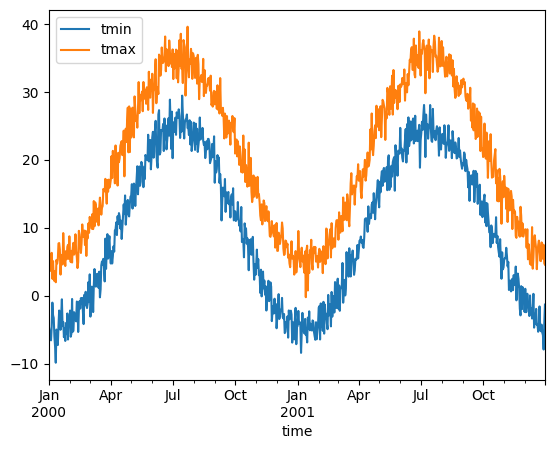

In [9]:
ds.mean(dim="location").to_dataframe().plot()
plt.show()

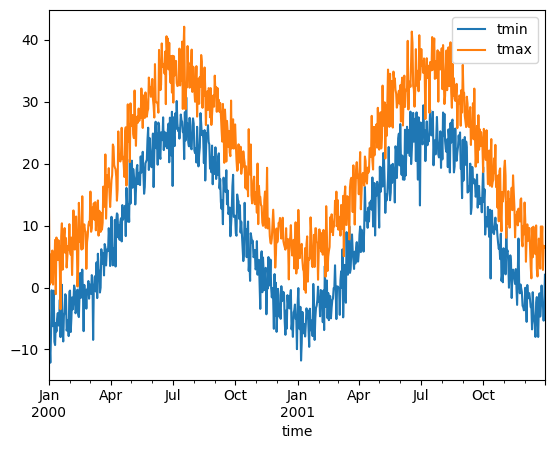

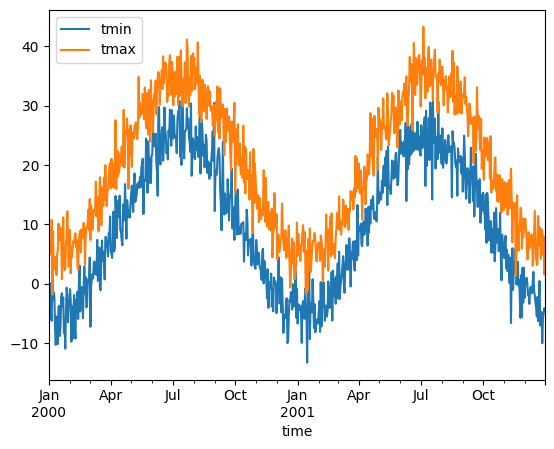

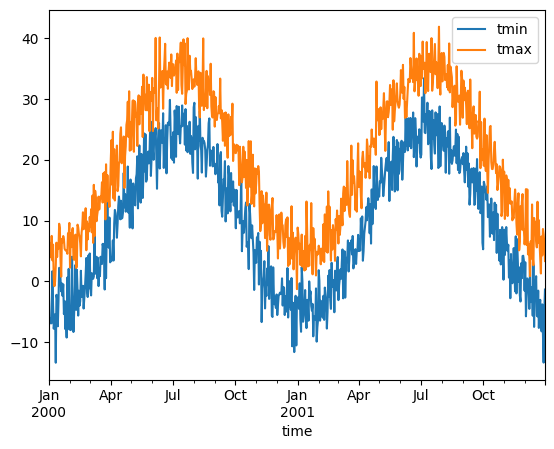

In [10]:
ds.sel(location='IA').to_dataframe().plot()
plt.show()

ds.sel(location='IL').to_dataframe().plot()
plt.show()

ds.sel(location='IN').to_dataframe().plot()
plt.show()

<Axes: ylabel='Frequency'>

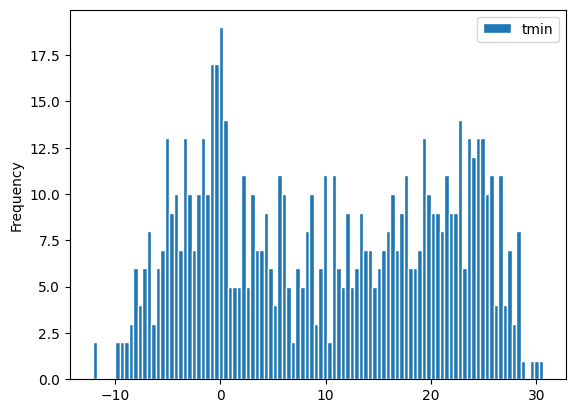

In [65]:
ds.sel(location='IA')['tmin'].to_dataframe().plot.hist(edgecolor='w', bins=100)

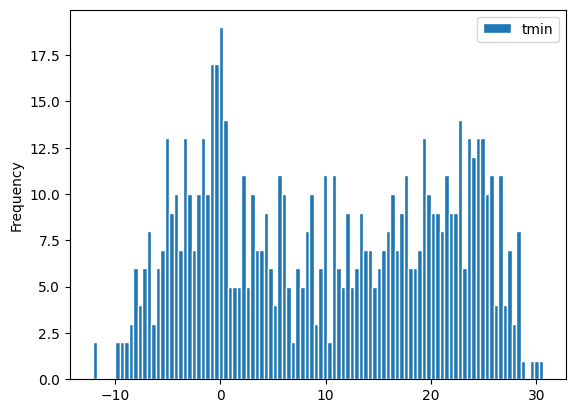

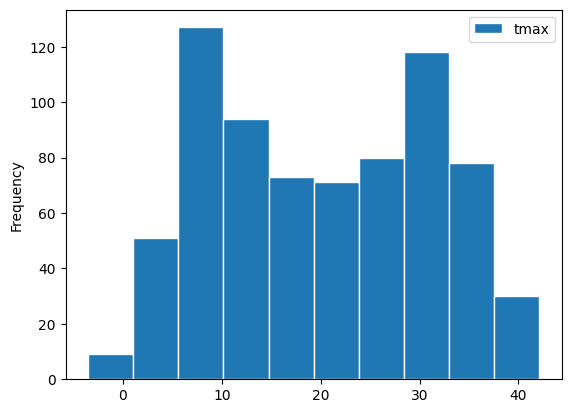

In [64]:
ds.sel(location='IA')['tmin'].to_dataframe().plot.hist(edgecolor='w', bins=100)
plt.show()

ds.sel(location='IA')['tmax'].to_dataframe().plot.hist(edgecolor='w')
plt.show()

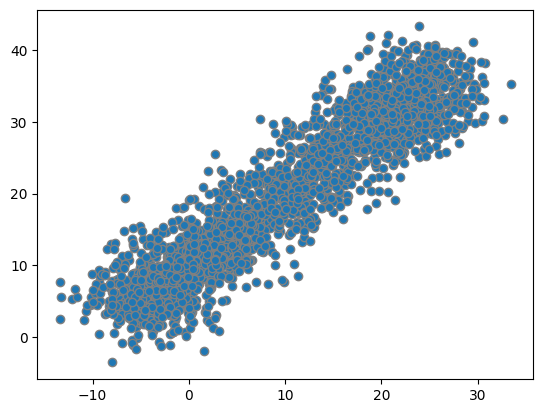

In [66]:
plt.scatter(ds['tmin'],ds['tmax'],edgecolor='grey')
plt.show()

In [13]:
# probability of a freeze by calendar month
freeze = (ds["tmin"] <= 0).groupby("time.month").mean("time")
freeze

<xarray.DataArray 'tmin' (month: 12, location: 3)>
array([[0.9516129 , 0.88709677, 0.93548387],
       [0.84210526, 0.71929825, 0.77192982],
       [0.24193548, 0.12903226, 0.16129032],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.01612903, 0.        ],
       [0.33333333, 0.35      , 0.23333333],
       [0.93548387, 0.85483871, 0.82258065]])
Coordinates:
  * location  (location) <U2 'IA' 'IN' 'IL'
  * month     (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

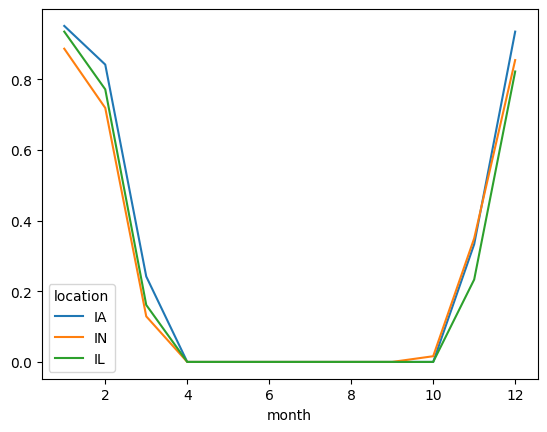

In [14]:
freeze.to_pandas().plot(); plt.show()

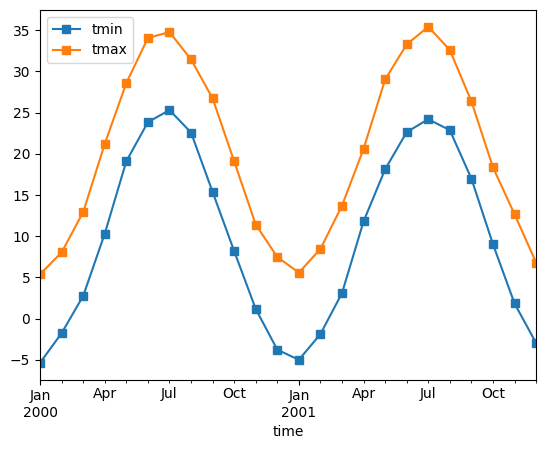

In [15]:
# monthly means
monthly_avg = ds.resample(time="1MS").mean()
monthly_avg.sel(location="IA").to_dataframe().plot(style="s-")
plt.show()

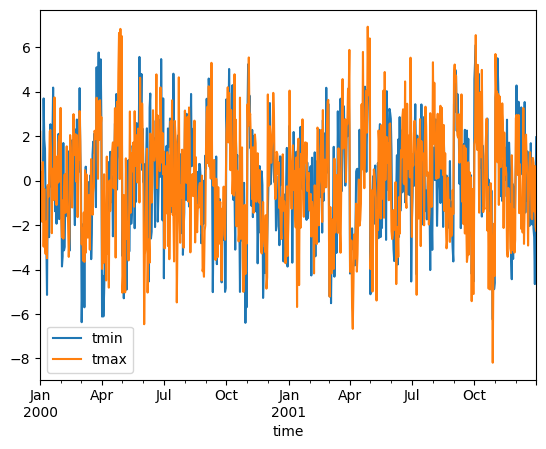

In [16]:
# calculate anomalies
climatology = ds.groupby("time.month").mean("time")
anomalies = ds.groupby("time.month") - climatology
anomalies.mean("location").to_dataframe()[["tmin", "tmax"]].plot()
plt.show()

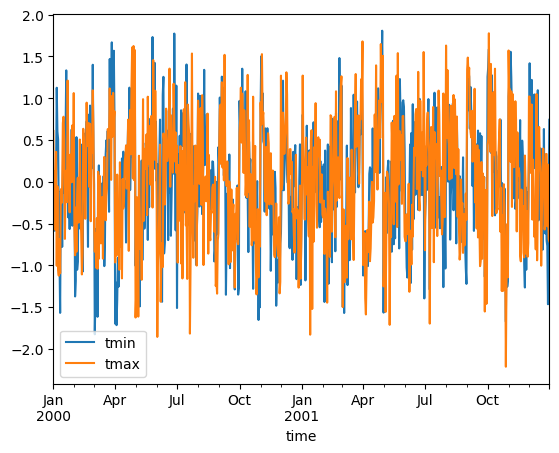

In [17]:
# calculate standardized anomalies
climatology_mean = ds.groupby("time.month").mean("time")
climatology_std = ds.groupby("time.month").std("time")
stand_anomalies = xr.apply_ufunc(
    lambda x, m, s: (x - m) / s,
    ds.groupby("time.month"),
    climatology_mean,
    climatology_std,
)

stand_anomalies.mean("location").to_dataframe()[["tmin", "tmax"]].plot()
plt.show()

### dimensionality reduction with principal component analysis

In [18]:
from sklearn.decomposition import PCA

"Principal component analysis (PCA) is a mathematical algorithm that reduces the dimensionality of the data while retaining most of the variation in the data set1. It accomplishes this reduction by identifying directions, called principal components, along which the variation in the data is maximal. By using a few components, each sample can be represented by relatively few numbers instead of by values for thousands of variables. Samples can then be plotted, making it possible to visually assess similarities and differences between samples and determine whether samples can be grouped." https://www.nature.com/articles/nbt0308-303

In [49]:
pca = PCA(n_components=2)

In [50]:
pca.fit(stand_anomalies['tmax'].values)
X = pca.transform(stand_anomalies['tmax'].values)

In [88]:
X.shape

(731, 2)

In [51]:
stand_anomalies['tmax'].values

array([[ 2.18595486, -0.73101033,  0.37025523],
       [-1.46955403,  0.37070665, -0.26905704],
       [-0.04767043,  0.32719325,  0.10653487],
       ...,
       [-0.15348026,  0.24752013,  0.51976964],
       [-0.25198427, -0.17884232, -1.63000248],
       [-0.1884713 , -1.06500857, -0.88533911]])

In [52]:
X[720:]

array([[-0.24586179, -1.78060105],
       [-0.70223357,  0.50964998],
       [-0.20648305, -1.05985484],
       [ 1.0273766 , -1.49206579],
       [ 0.81565861,  0.30859861],
       [-0.55944397, -0.68636369],
       [-0.56256399, -0.60318307],
       [ 0.92416261,  0.04574437],
       [-0.34419592, -0.38681118],
       [ 1.16039679,  1.18556309],
       [ 1.22837577,  0.2249415 ]])

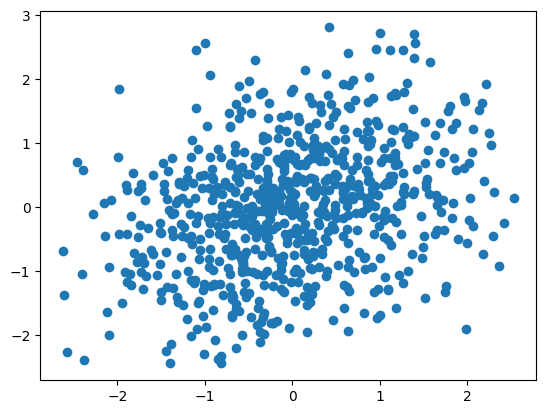

In [53]:
plt.scatter(stand_anomalies['tmax'][:,0],stand_anomalies['tmax'][:,1])

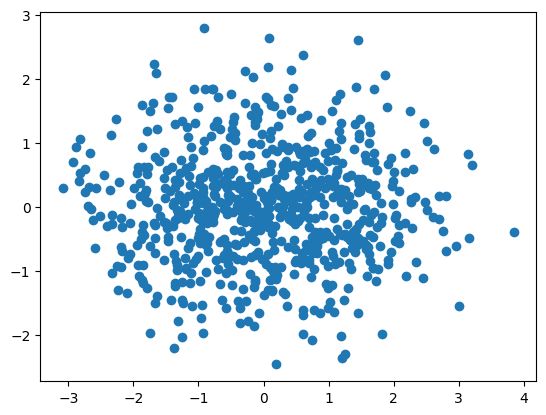

In [55]:
plt.scatter(X[:,0],X[:,1])

In [56]:
print(pca.explained_variance_ratio_)

[0.51798728 0.25046885]


Other dimensionality reduction can also be feature selection and feature extraction. See https://scikit-learn.org/stable/modules/feature_selection.html for examples

### labels section

When using various input variables (i.e., features or channels), normalizing or standardizing the variables is needed to make sure they have a similar dynamic range. Otherwise, some input variables may have much larger magnitudes than other input variables, limiting their contributions to the learning process. By normalizing/standardizing our features, we facilitate meaningful comparisons between features. This practice can also improve machine learning model convergence.

Standardization involves centering the respective data to have a mean of zero and a standard deviation of one, which can be achieved by subtracting the mean and dividing by the standard deviation (i.e., z-score). Normalization involves the scaling of data to a set range, such as from 0 to +1 or -1 to +1, by using the minimum and maximum values of the respective variable.

Here we have some helper functions for normalizing and standardizing our data using numpy.

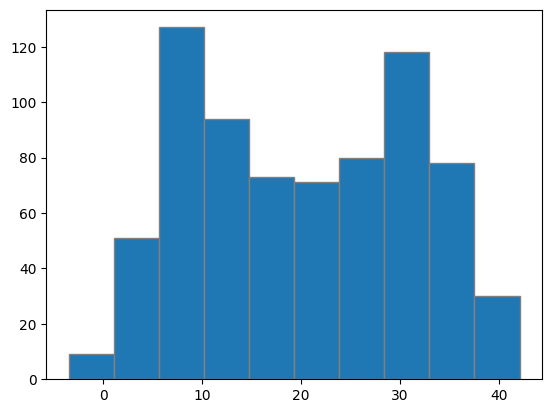

In [72]:
freq = plt.hist(ds['tmax'].isel(location=0), edgecolor='grey')
#plt.show()

In [75]:
freq[0]

array([  9.,  51., 127.,  94.,  73.,  71.,  80., 118.,  78.,  30.])

In [77]:
freq[1]

array([-3.50623398,  1.05318194,  5.61259786, 10.17201378, 14.7314297 ,
       19.29084562, 23.85026154, 28.40967746, 32.96909338, 37.5285093 ,
       42.08792523])

In [80]:
def z_score(da): 
    """ Compute z-score for training data. 
    Normalizing data for ML model training. 
    Args: da (array): Array of training variable. """ 
    return (da - np.mean(da)) / np.std(da) 
    
def min_max_scale(da): 
    """ Scale training data by minimum and maximum values. 
    Args: da (array): Array of training variable. """ 
    return (da - np.min(da)) / (np.max(da) - np.min(da))

In [81]:
def z_score(da): 
    """ Compute z-score for training data. 
    Normalizing data for ML model training. 
    Args: da (array): Array of training variable. """ 
    return (da - np.mean(da)) / np.std(da), np.mean(da), np.std(da)

def z_score_test(da, mn, std): 
    """ Compute z-score for training data. 
    Normalizing data for ML model training. 
    Args: da (array): Array of training variable. """ 
    return (da - mn) / std

In [83]:
zscore, mn, std = z_score(ds['tmax'].isel(location=0))

In [85]:
mn

<xarray.DataArray 'tmax' ()>
array(20.2112185)
Coordinates:
    location  <U2 'IA'

In [86]:
std

<xarray.DataArray 'tmax' ()>
array(10.98600953)
Coordinates:
    location  <U2 'IA'

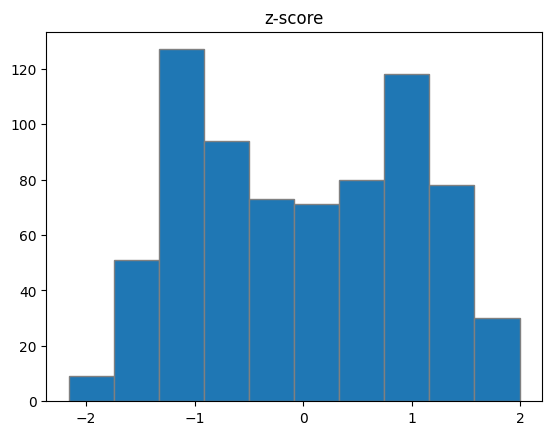

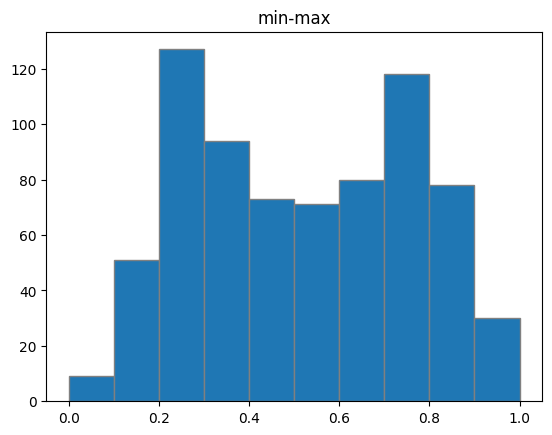

In [79]:
plt.hist(z_score(ds['tmax'].isel(location=0)), edgecolor='grey') 
plt.title('z-score') 
plt.show() 

plt.hist(min_max_scale(ds['tmax'].isel(location=0)), edgecolor='grey')
plt.title('min-max') 
plt.show()

In [87]:
def random_split(data, label, split=0.3, seed=0):
    """
    Help splitting data randomly for training and testing.
    """
    np.random.seed(0)
    da_indx = np.random.permutation(data.shape[0])
    data  = data[da_indx.astype(int)]
    label = label[da_indx.astype(int)]
    init_range = int(data.shape[0] * (1 - 0.3))
    return data[:init_range], label[:init_range], data[init_range:], label[init_range:]

As we can see on the x-axis in the above images, z-score results in our data having a mean of zero while min-max results in our data spanning values from 0 to +1, with both methods not changing the actual distribution of our data.

The two classes will be creating using integer encoding first, with 0 representing 20C or colder and 1 representing potentially warmer than 20C, and then converting using one-hot encoding for subsequent training.

In [ ]:
random_split(data, label, split=0.3, seed=0)